In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy as sp
import matplotlib.pyplot as plt

az.style.use('arviz-darkgrid')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Medium

## 12M1

In [5]:
frogs = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/reedfrogs.csv',
                    sep=",")

tanks = np.arange(frogs.shape[0])

In [6]:
frogs.head()

density pred   size  surv  propsurv
0       10   no    big     9       0.9
1       10   no    big    10       1.0
2       10   no    big     7       0.7
3       10   no    big    10       1.0
4       10   no  small     9       0.9

In [29]:
# Create dummies
frogs_df = pd.get_dummies(frogs, columns = ['pred', 'size'])\
             .drop(['pred_no', 'size_small'], axis = 1)\
             .rename(columns = {'size_big' : 'size',
                                'pred_pred' : 'pred'})\

# Create interactive variable
frogs_df['size_pred'] = frogs_df['size'] * frogs_df['pred']

frogs_df.head()

density  surv  propsurv  pred  size  size_pred
0       10     9       0.9     0     1          0
1       10    10       1.0     0     1          0
2       10     7       0.7     0     1          0
3       10    10       1.0     0     1          0
4       10     9       0.9     0     0          0

In [34]:
with pm.Model() as m_12_1_clust:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Normal('a_tank', a, sigma, shape = frogs_df.shape[0])
    
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_1_clust = pm.sample(2000, tune=2000)

with pm.Model() as m_12_1_pred:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Normal('a_tank', a, sigma, shape = frogs_df.shape[0])
    bpred = pm.Normal('bpred', 0, 1)
    
    p = pm.math.invlogit(a_tank[tank] + bpred * frogs_df['pred'])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_1_pred = pm.sample(2000, tune=2000)
    
with pm.Model() as m_12_1_size:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Normal('a_tank', a, sigma, shape = frogs_df.shape[0])
    bsize = pm.Normal('bsize', 0, 1)
    
    p = pm.math.invlogit(a_tank[tank] + bsize * frogs_df['size'])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_1_size = pm.sample(2000, tune=2000)
    
with pm.Model() as m_12_1_both:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Normal('a_tank', a, sigma, shape = frogs_df.shape[0])
    bpred = pm.Normal('bpred', 0, 1)
    bsize = pm.Normal('bsize', 0, 1)
    
    p = pm.math.invlogit(a_tank[tank] + bpred * frogs_df['pred'] + bsize * frogs_df['size'])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_1_both = pm.sample(2000, tune=2000)
    
with pm.Model() as m_12_1_interact:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Normal('a_tank', a, sigma, shape = frogs_df.shape[0])
    bpred = pm.Normal('bpred', 0, 1)
    bsize = pm.Normal('bsize', 0, 1)
    binteract = pm.Normal('binteract', 0, 1)
    
    p = pm.math.invlogit(a_tank[tank] + bpred * frogs_df['pred'] + bsize * frogs_df['size'] + binteract * frogs_df['size_pred'])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_1_interact = pm.sample(2000, tune=2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2206.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bpred, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:13<00:00, 1202.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bsize, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:12<00:00, 1233.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bsize, bpred, a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:16<00:00, 989.20draws/s]
The number o

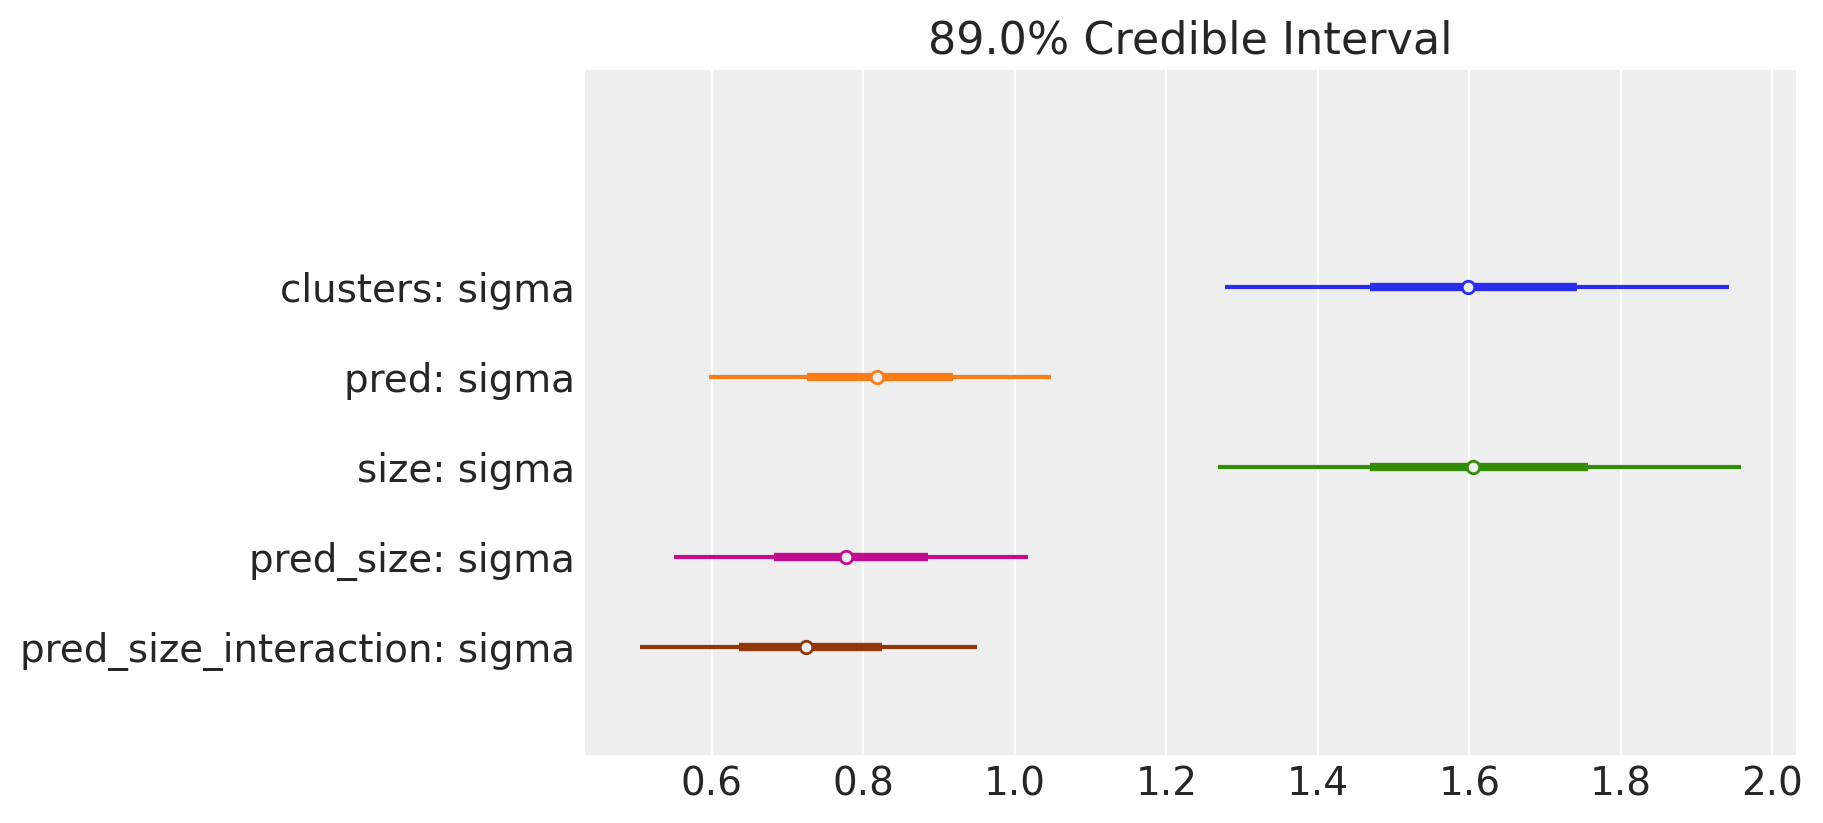

In [36]:
az.plot_forest([trace_12_1_clust, trace_12_1_pred, trace_12_1_size, trace_12_1_both, trace_12_1_interact], 
               model_names=["clusters", "pred", "size", "pred_size", "pred_size_interaction"], 
               var_names=["sigma"], credible_interval=.89, figsize=(9,4), combined=True);

More variation between clusters when no predictor variables. Adding variables absorb varation, so the variation between clusters become smaller. Size variable does not account for much variation so sigma is roughly the same as no predictor model.

## 12M2

In [42]:
az.compare({"clusters": trace_12_1_clust, 
            "pred": trace_12_1_pred, 
            "size": trace_12_1_size, 
            "both": trace_12_1_both, 
            "interaction": trace_12_1_interact}, 
           method="pseudo-BMA")

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank     waic   p_waic    d_waic    weight       se      dse  \
pred           0  199.033  19.1571         0  0.347514  8.77803        0   
interaction    1  199.738  19.0029  0.704627  0.244323  9.30901  3.27143   
both           2  200.654   19.493   1.62073  0.154538  8.54263  1.60175   
clusters       3  200.823  21.2095   1.79014  0.141987  7.15323  5.36555   
size           4  201.304  21.4249   2.27111  0.111637  7.10334  5.57141   

            warning waic_scale  
pred           True   deviance  
interaction    True   deviance  
both           True   deviance  
clusters       True   deviance  
size           True   deviance

Size only predictor has the weakest performance. Suggests that it's not an important variable.

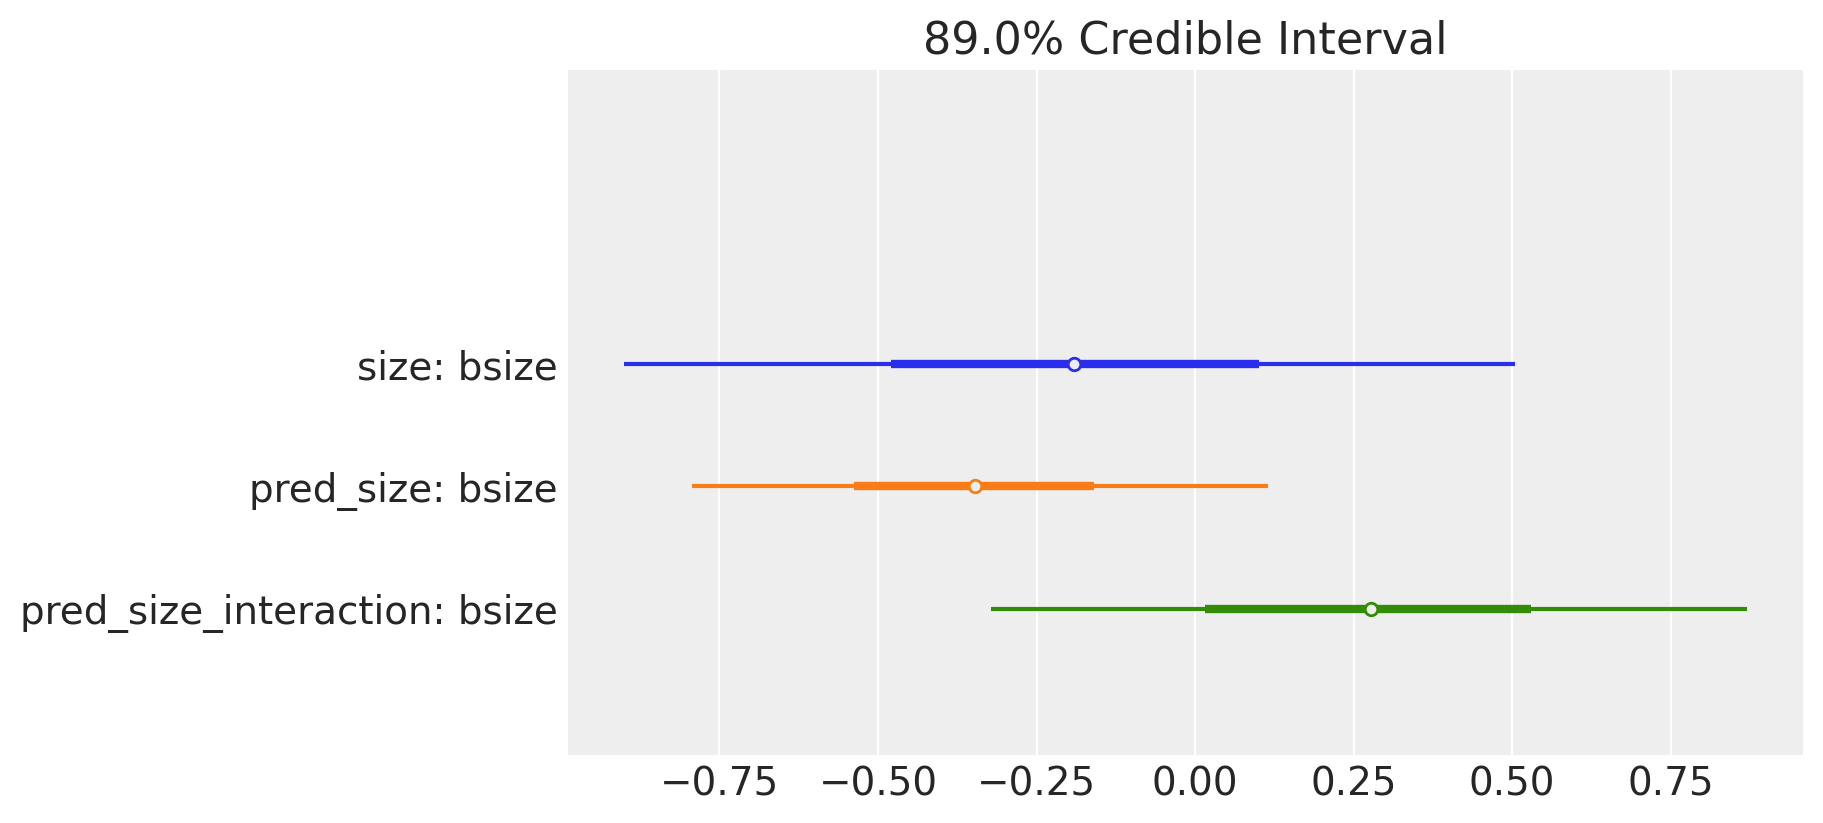

In [58]:
az.plot_forest([trace_12_1_size, trace_12_1_both, trace_12_1_interact], 
               model_names=["size", "pred_size", "pred_size_interaction"], 
               var_names=["bsize"], credible_interval=.89, figsize=(9,4), combined=True);

All instances of the size coefficient CI crosses zero. This is consistent with size not explaining much variation. However, this does not necessarily mean size is not an _important_ variable. There may be masking effects from omitted variables which may disguise its influence on the outcome.

## 12M3

In [60]:
with pm.Model() as m_12_3_clust:
    a = pm.Normal('a', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    a_tank = pm.Cauchy('a_tank', a, sigma, shape = frogs_df.shape[0])
    
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=frogs_df['density'], p=p, observed=frogs_df['surv'])
    trace_12_3_clust = pm.sample(4000, tune=2000, nuts_kwargs={"target_accept": .99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_tank, sigma, a]
Sampling 4 chains: 100%|██████████| 24000/24000 [10:11<00:00, 39.24draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Following the guidance of the PyMC3 devs notebook, compare the posterior means of each tank between models by using a scatterplot.

In [69]:
cauchy = pm.trace_to_dataframe(trace_12_3_clust)\
           .drop(["a", "sigma"], axis=1).mean()

gauss = pm.trace_to_dataframe(trace_12_1_clust)\
           .drop(["a", "sigma"], axis=1).mean()

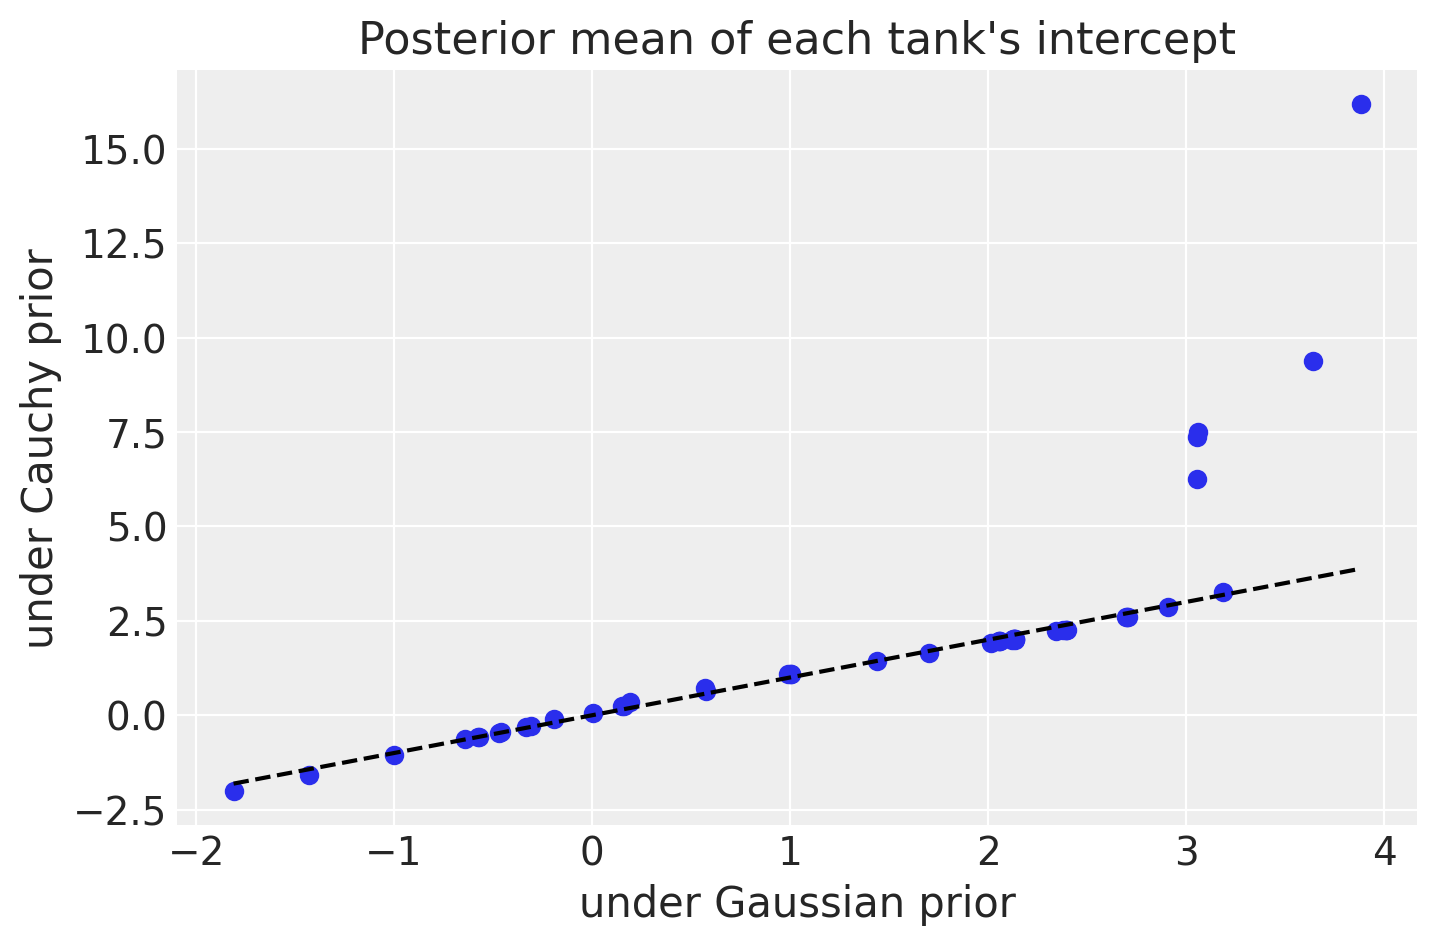

In [87]:
plt.figure(figsize=(8,5))
plt.scatter(x=gauss, y=cauchy)
plt.plot([gauss.min(), gauss.max()], [gauss.min(), gauss.max()], "k--")
plt.xlabel("under Gaussian prior")
plt.ylabel("under Cauchy prior")
plt.title("Posterior mean of each tank's intercept");

Means for larger tank intercepts are more extreme under cauchy prior.

## 12M4

In [91]:
chimp = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/chimpanzees.csv',
                    sep = ';')

# Reset index to zero
chimp.actor = chimp.actor -1
chimp.block = chimp.block-1

In [93]:
chimp.head()

actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0      0        NaN          0      0      2            0             1   
1      0        NaN          0      0      4            0             0   
2      0        NaN          0      0      6            1             0   
3      0        NaN          0      0      8            0             1   
4      0        NaN          0      0     10            1             1   

   pulled_left  
0            0  
1            1  
2            0  
3            0  
4            1

In [95]:
chimp.actor.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [106]:
with pm.Model() as m_12_4_1:
    alpha = pm.Normal('alpha', 0, 10)
    gamma = pm.Normal('gamma', 0, 10)
    sigma_a = pm.HalfCauchy('sigma_a', 1)
    sigma_b = pm.HalfCauchy('sigma_b', 1)
    
    a_actor = pm.Normal('a_actor', alpha, sigma_a, shape = len(chimp['actor'].unique()))
    a_block = pm.Normal('a_gamma', gamma, sigma_b, shape = len(chimp.['block'].unique()))
    bp = pm.Normal('bp', 0, 1)
    bpC = pm.Normal('bpC', 0, 1)
    
    p = pm.math.invlogit(a_actor[chimp.actor.values] + a_block[chimp.block.values]+ (bp + bpC * chimp.condition) * chimp.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=chimp.pulled_left)

    trace_12_4_1 = pm.sample(2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bpC, bp, a_gamma, a_actor, sigma_b, sigma_a, gamma, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [04:58<00:00, 67.05draws/s]
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.884139214309475, but should be close to 0.8. Try to increase the number of tuning steps.
There were 465 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6278207290205848, but should be close to 0.8. Try to increase the number of tuning steps.
There were 403 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6600231582186595, but should be close to 0.8. Try to increase the number of tuning steps.
There were 250 divergences af

In [117]:
with pm.Model() as m_12_4_2:
    alpha = pm.Normal('alpha', 0, 10)
    sigma_a = pm.HalfCauchy('sigma_a', 1)
    sigma_b = pm.HalfCauchy('sigma_b', 1)
    
    a_actor = pm.Normal('a_actor', 0, sigma_a, shape=len(chimp['actor'].unique()))
    a_block = pm.Normal('a_block', 0, sigma_b, shape=len(chimp['block'].unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    p = pm.math.invlogit(alpha + a_actor[chimp.actor.values] + a_block[chimp.block.values] + (bp + bpC * chimp.condition) * chimp.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=chimp.pulled_left)

    trace_12_4_2 = pm.sample(2000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a_block, a_actor, sigma_b, sigma_a, alpha]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:40<00:00, 247.04draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [108]:
az.summary(trace_12_4_1, var_names=["alpha", 'gamma', "bp", "bpC", "sigma_a", "sigma_b"], credible_interval=0.89)

mean     sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha    0.122  7.032   -11.434     10.743      0.287    0.203     601.0   
gamma    0.340  7.013    -9.815     12.156      0.285    0.202     605.0   
bp       0.783  0.255     0.411      1.237      0.012    0.010     454.0   
bpC     -0.109  0.292    -0.576      0.380      0.014    0.012     455.0   
sigma_a  2.239  0.889     1.113      3.357      0.020    0.014    1904.0   
sigma_b  0.319  0.185     0.096      0.528      0.009    0.006     444.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
alpha     601.0     602.0     851.0   1.01  
gamma     605.0     605.0     756.0   1.01  
bp        334.0     485.0     226.0   1.02  
bpC       312.0     489.0     155.0   1.01  
sigma_a  1904.0    1936.0    2467.0   1.02  
sigma_b   444.0     201.0     126.0   1.03

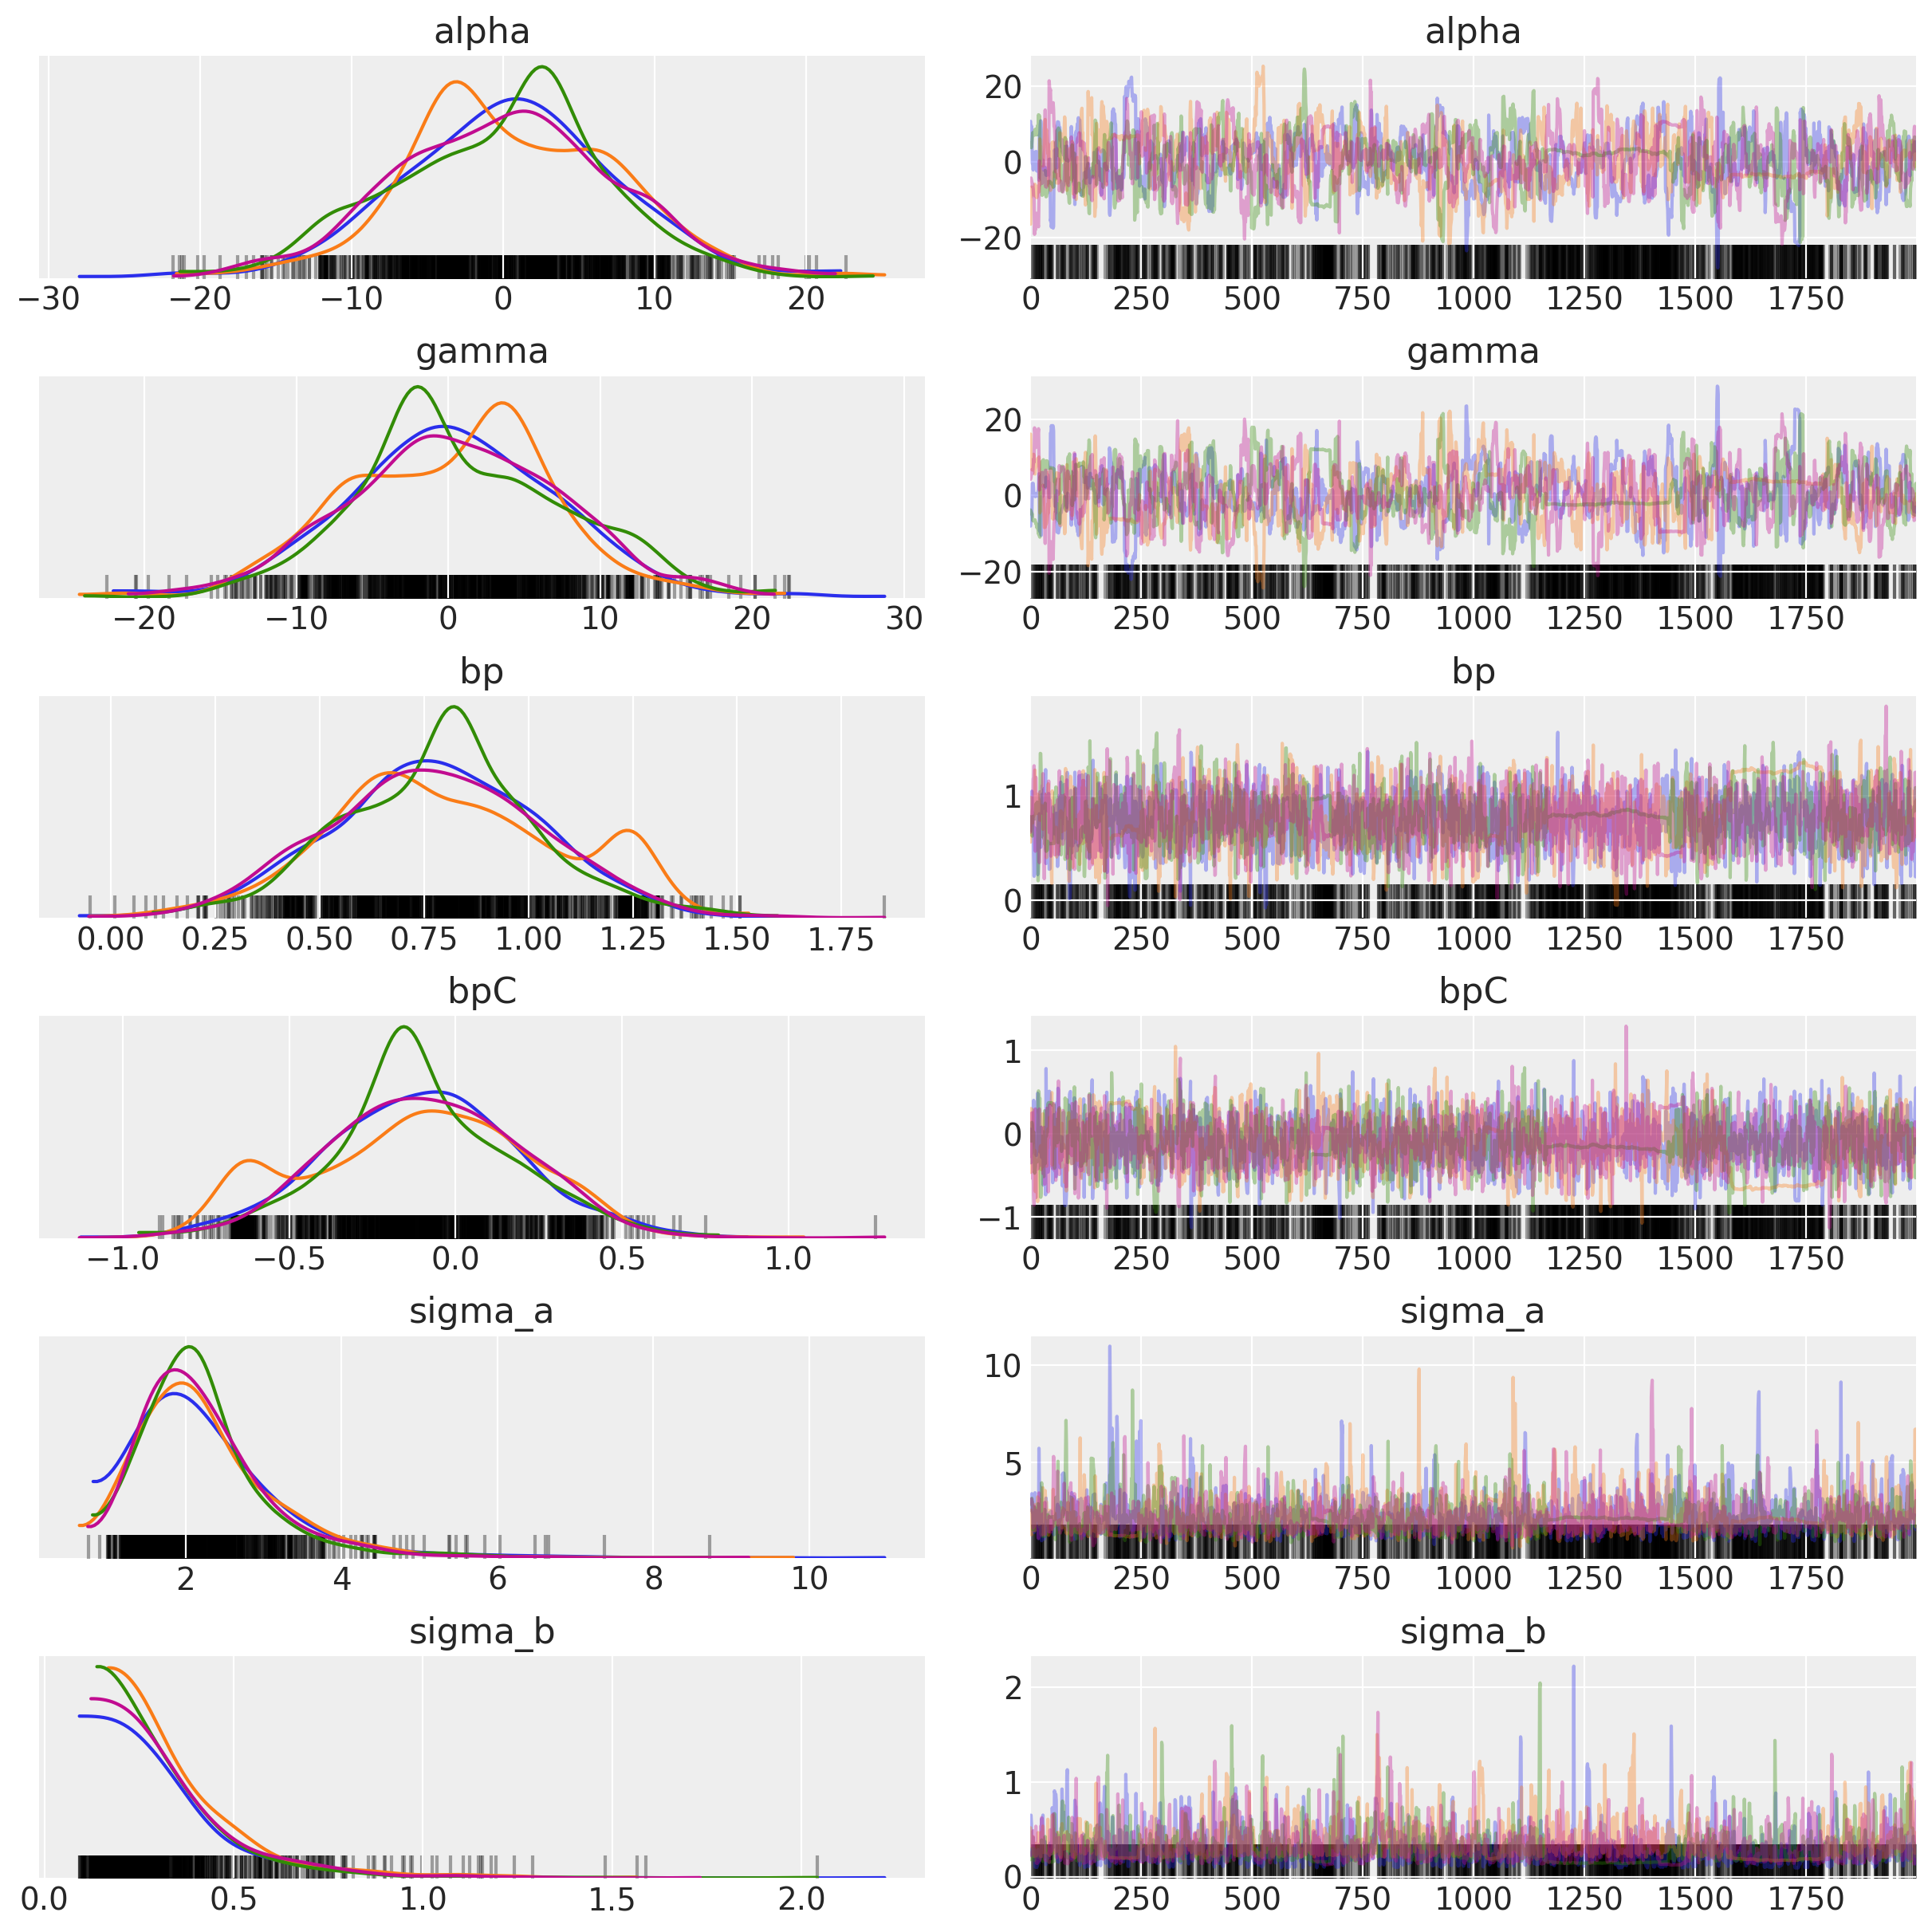

In [114]:
az.plot_trace(trace_12_4_1, var_names=["alpha", 'gamma', "bp", "bpC", "sigma_a", "sigma_b"]);

In [105]:
az.summary(trace_12_4_2, var_names=["alpha", "bp", "bpc", "sigma_a", "sigma_b"], credible_interval=0.89)

mean     sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
alpha    0.529  1.010    -0.954      2.117      0.036    0.027     770.0   
bp       0.827  0.266     0.395      1.241      0.005    0.003    3124.0   
bpc     -0.136  0.301    -0.629      0.331      0.005    0.005    3007.0   
sigma_a  2.299  0.959     1.010      3.399      0.029    0.020    1131.0   
sigma_b  0.228  0.173     0.012      0.435      0.007    0.005     633.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
alpha     722.0     821.0     747.0    1.0  
bp       3101.0    3128.0    2581.0    1.0  
bpc      2189.0    2999.0    2843.0    1.0  
sigma_a  1131.0    1403.0    1325.0    1.0  
sigma_b   633.0     430.0     402.0    1.0

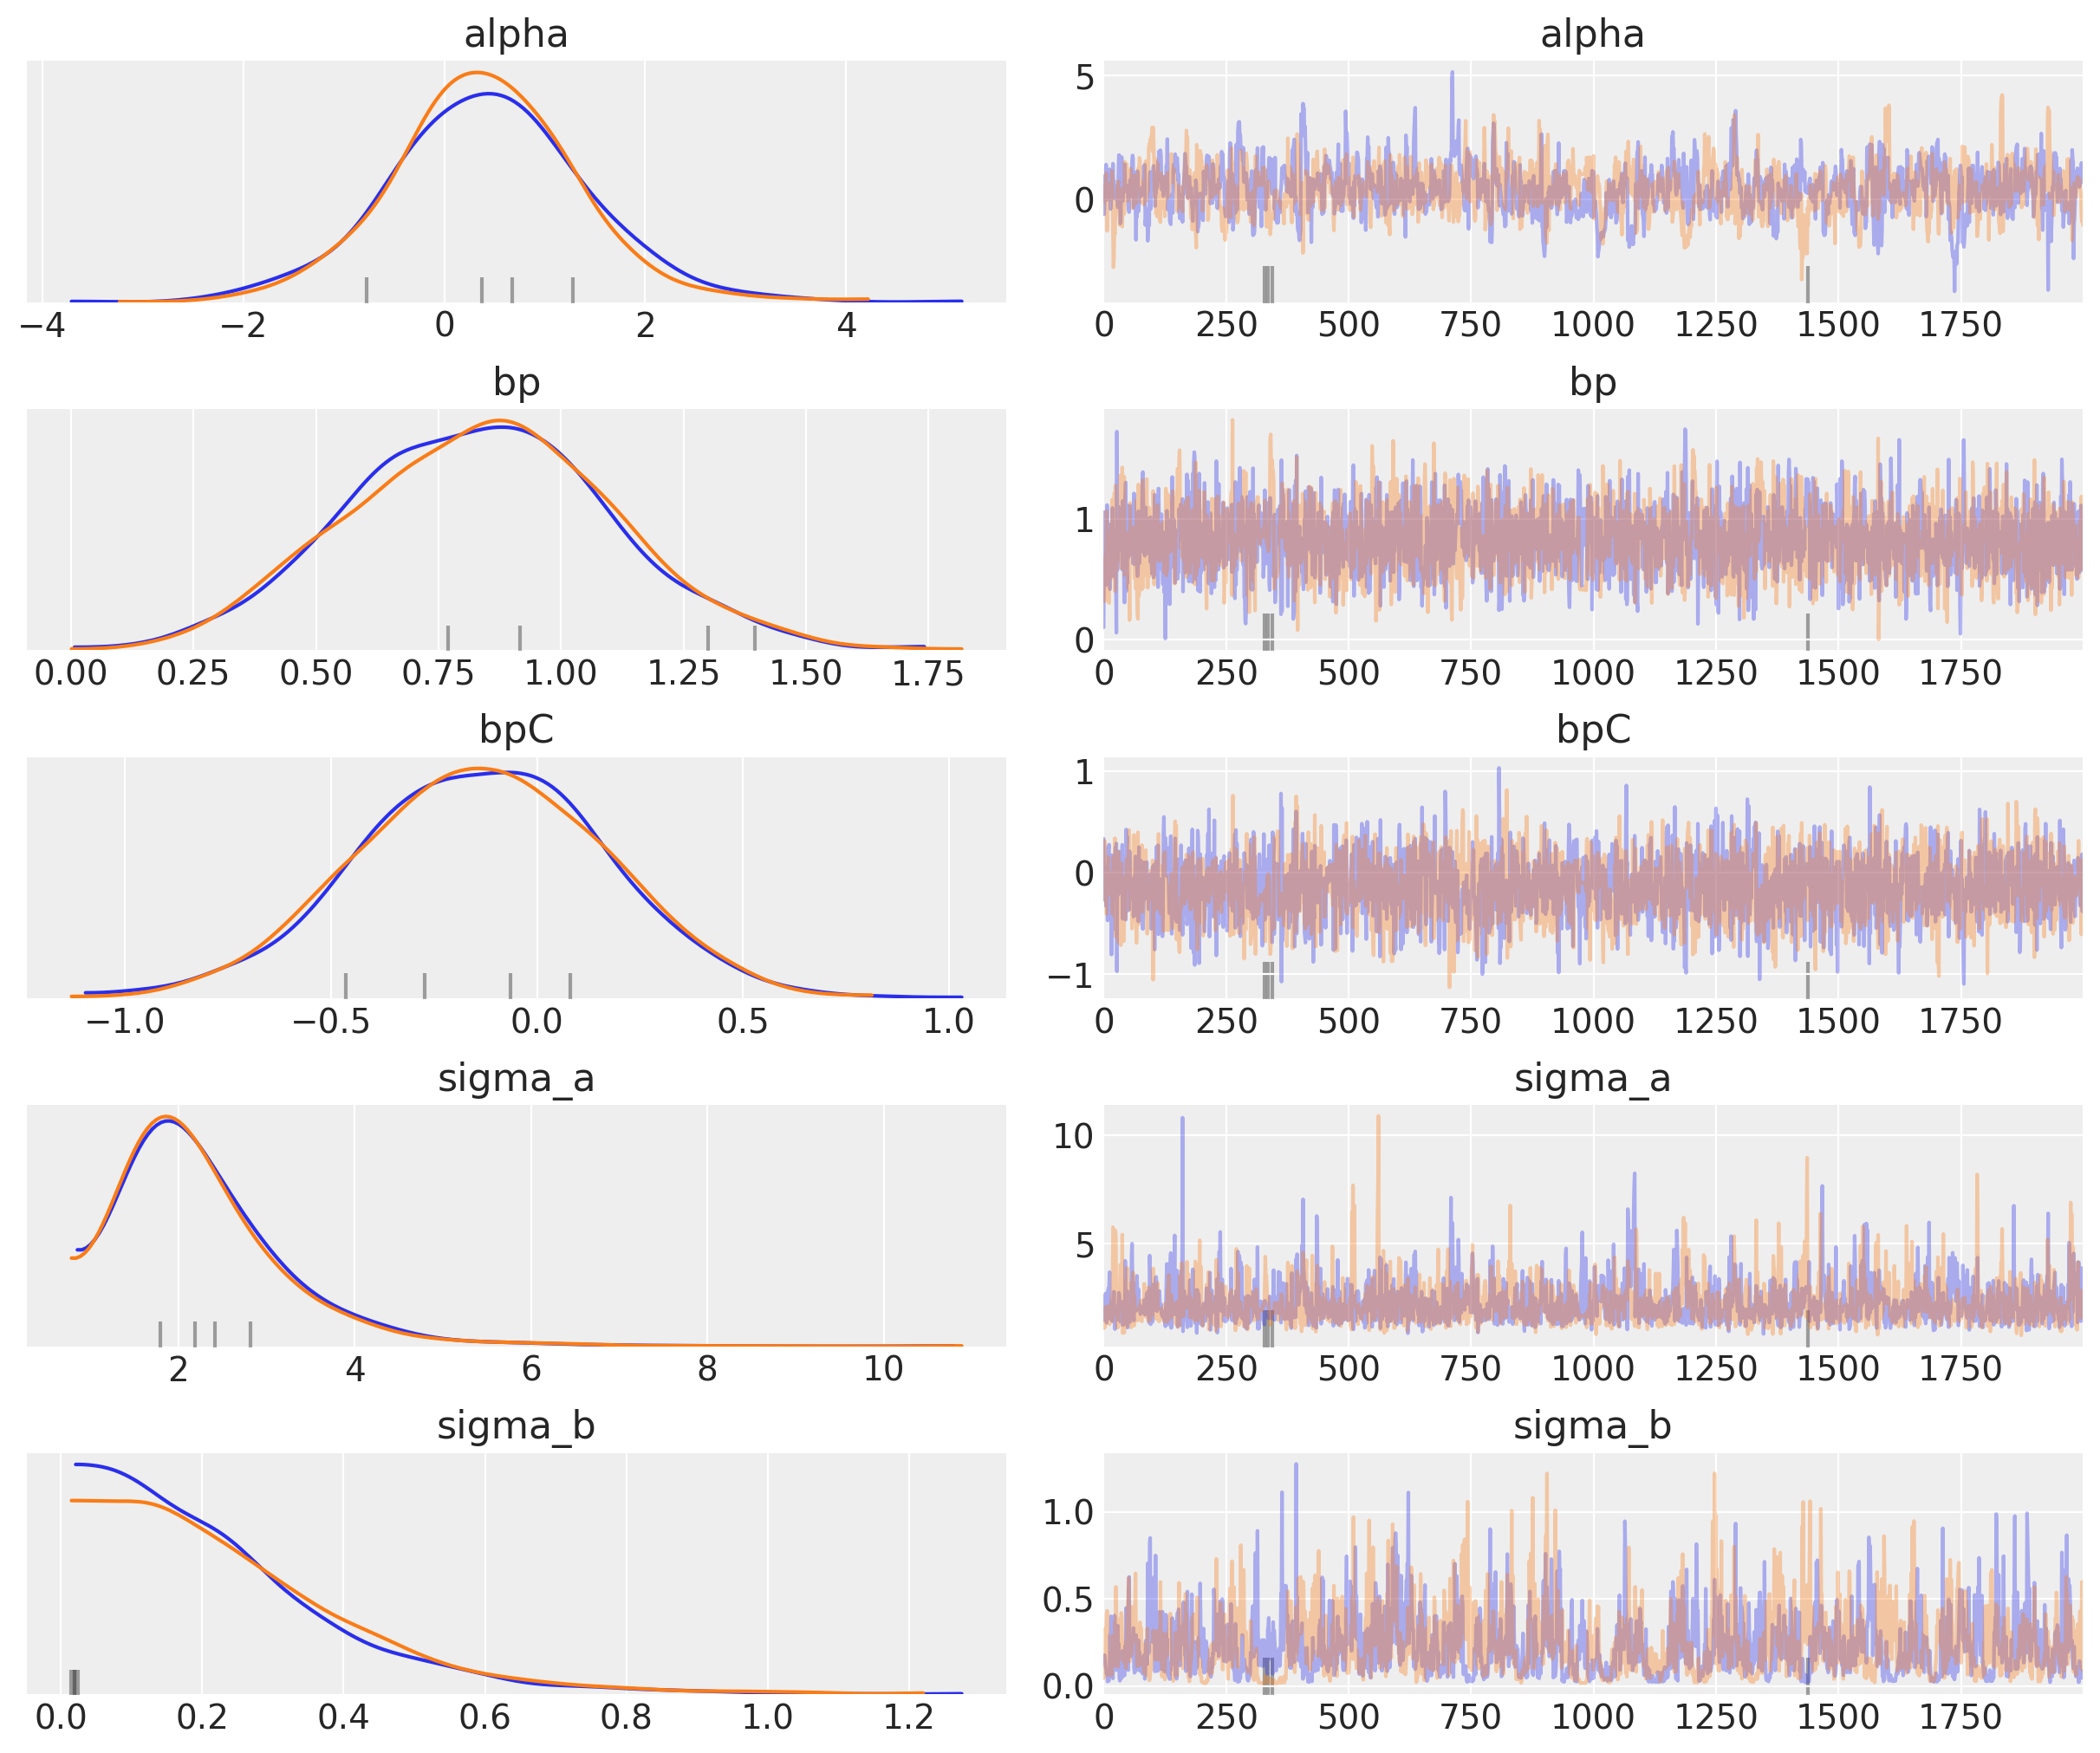

In [118]:
az.plot_trace(trace_12_4_2, var_names=["alpha",  "bp", "bpC", "sigma_a", "sigma_b"]);

Two grand means for m_12_4_1 -- intercept is over parameterised. Infinite combination of gamma and alpha produce the same sum. Similar problem occurs with two perfectly multicollinear covariates. 

## 12H1

In [132]:
df = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/bangladesh.csv', sep=";")
df.head()

woman  district  use.contraception  living.children  age.centered  urban
0      1         1                  0                4       18.4400      1
1      2         1                  0                1       -5.5599      1
2      3         1                  0                3        1.4400      1
3      4         1                  0                4        8.4400      1
4      5         1                  0                1      -13.5590      1

In [133]:
df['district_id'] = pd.factorize(df['district'], sort=True)[0]
district_id = df['district_id'].values
n_district = len(df['district_id'].unique())

df.head()

woman  district  use.contraception  living.children  age.centered  urban  \
0      1         1                  0                4       18.4400      1   
1      2         1                  0                1       -5.5599      1   
2      3         1                  0                3        1.4400      1   
3      4         1                  0                4        8.4400      1   
4      5         1                  0                1      -13.5590      1   

   district_id  
0            0  
1            0  
2            0  
3            0  
4            0

In [136]:
with pm.Model() as m_12_h1_fixed:
    a_district = pm.Normal('a_district', 0, 10, shape = n_district)
    
    p = pm.math.invlogit(a_district[district_id])
    use_contraception = pm.Binomial('use_contraception', n =1 , p=p, observed=df['use.contraception'])
    trace_12_h1_fixed = pm.sample(2000, tune=2000)
    
with pm.Model() as m_12_h1_pp:
    alpha = pm.Normal('alpha', 0, 10)
    sigma = pm.HalfCauchy('sigma', 1)
    a_district = pm.Normal('a_district', 0, sigma, shape = n_district)
    
    p = pm.math.invlogit(alpha + a_district[district_id])
    use_contraception = pm.Binomial('use_contraception', n =1 , p=p, observed=df['use.contraception'])
    trace_12_h1_pp = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_district]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:20<00:00, 768.14draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_district, sigma, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:15<00:00, 1065.21draws/s]


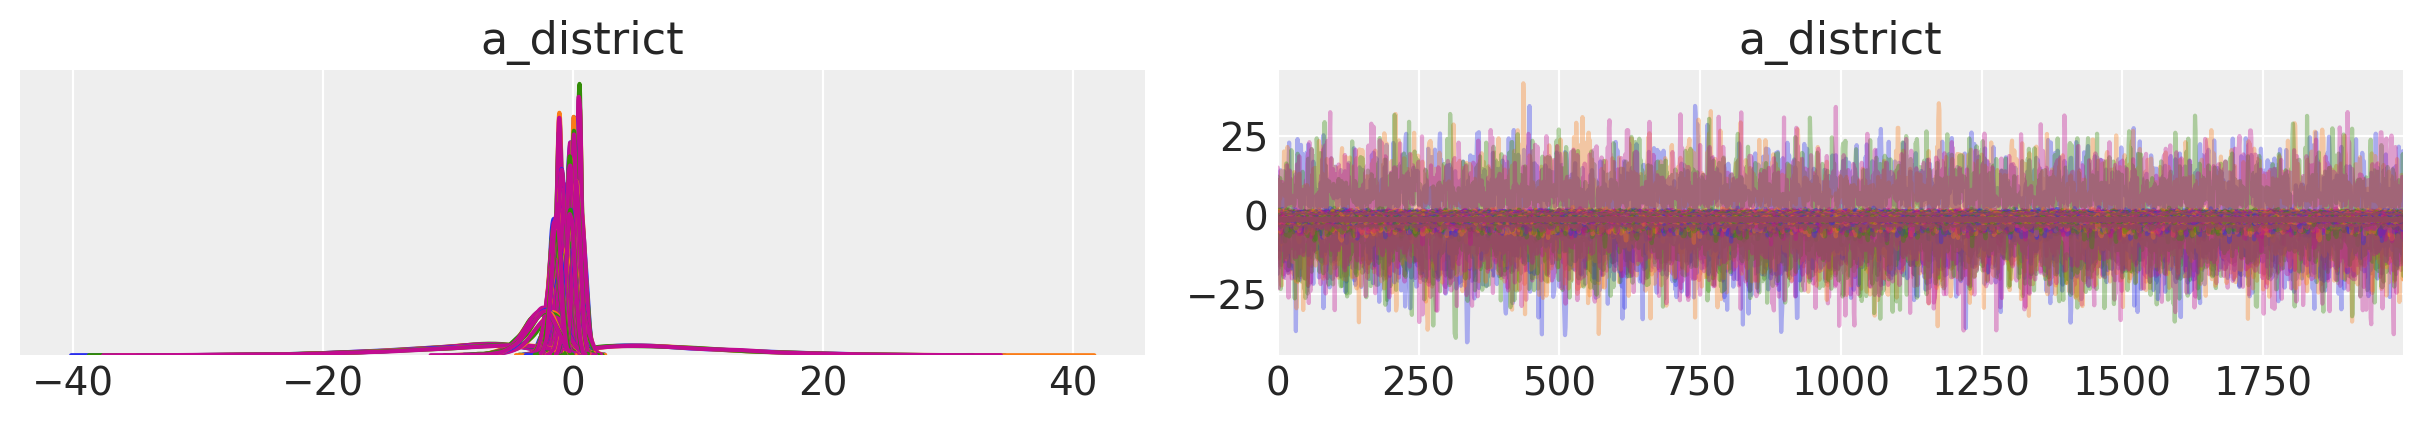

In [137]:
az.plot_trace(trace_12_h1_fixed, compact=True);

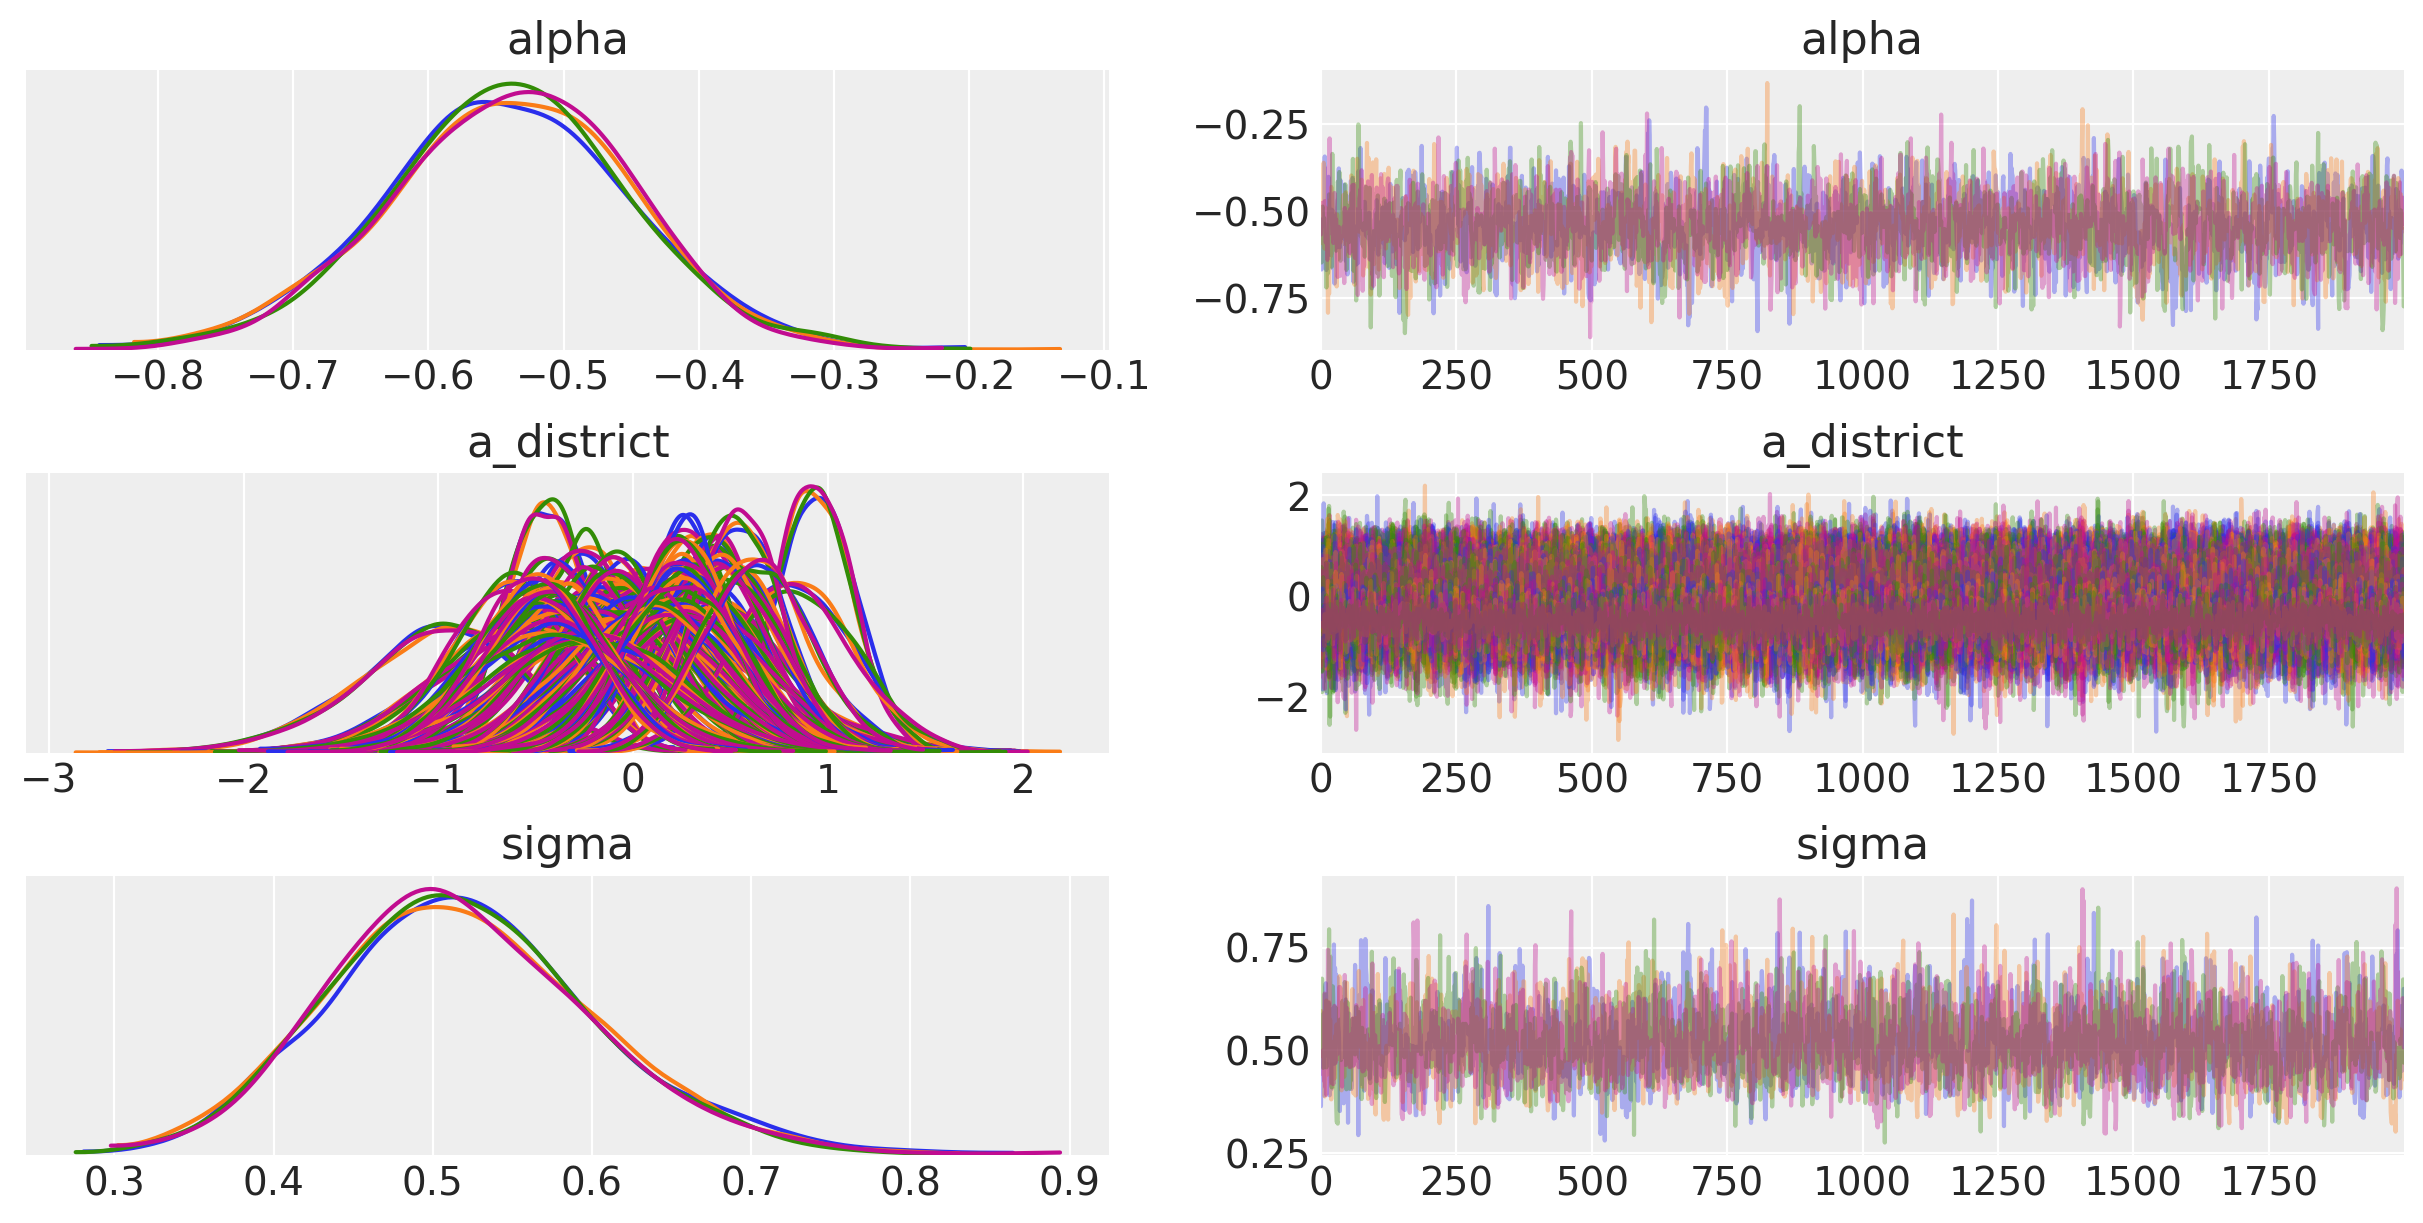

In [138]:
az.plot_trace(trace_12_h1_pp, compact=True);

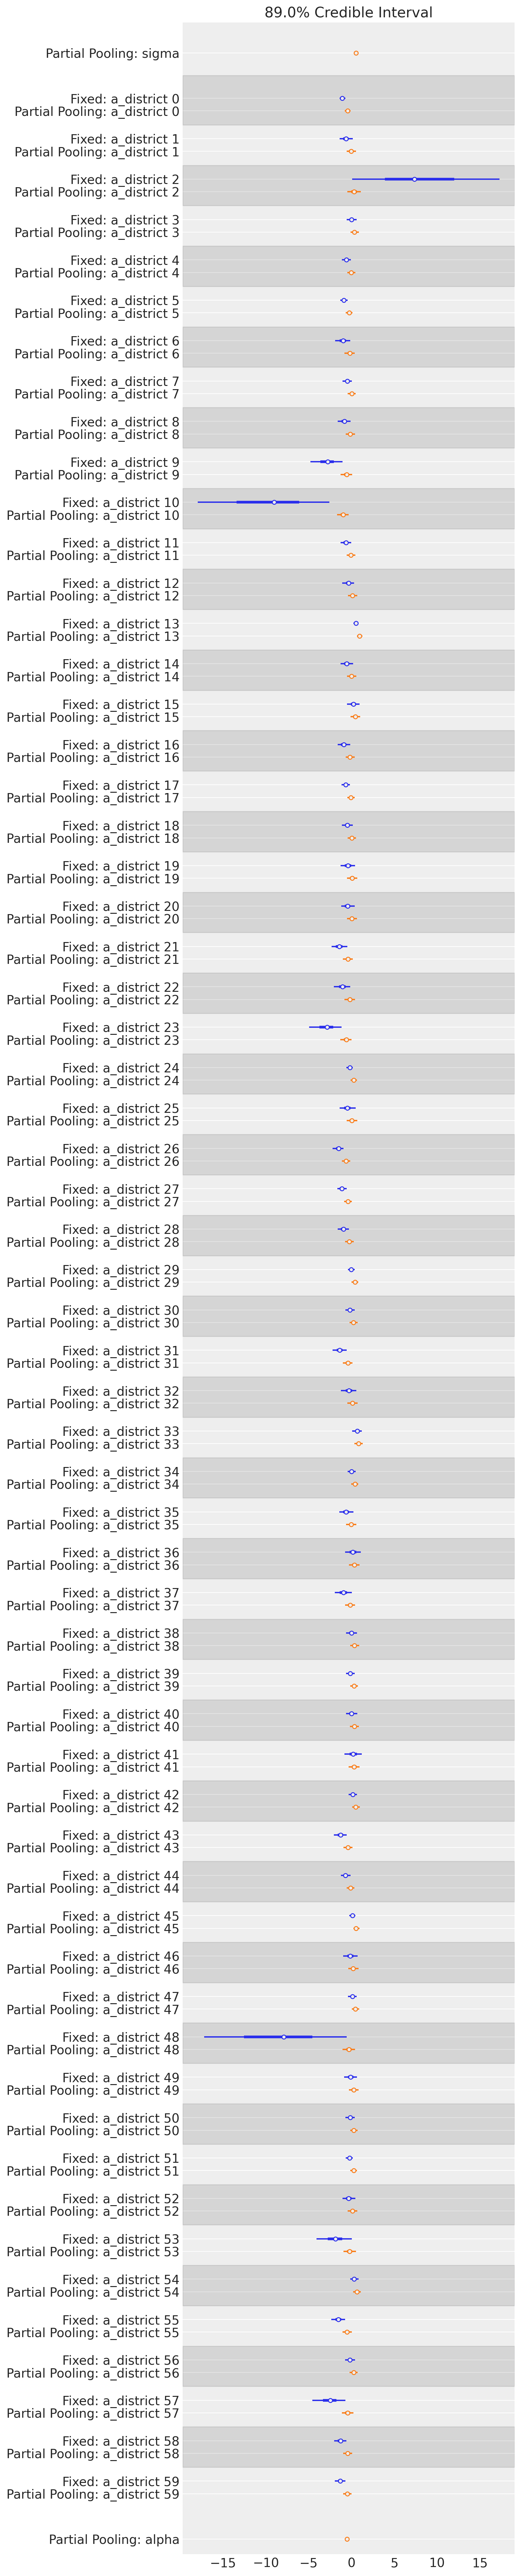

In [140]:
fig, axes = az.plot_forest([trace_12_h1_fixed, trace_12_h1_pp], model_names=["Fixed", "Partial Pooling"], 
                           credible_interval=0.89, 
                           combined=True, 
                           figsize=(8,40))
axes[0].grid();

Large uncertainty intervals around some fixed effects estimates. Small sample sizes + high variance. Partial pooling through adaptive regularisation give better estimates due to greater shrinkage towards grand mean.

In [158]:
# Fixed mean
fixed_df = pm.trace_to_dataframe(trace_12_h1_fixed)
fixed_mean = sp.special.expit(fixed_df.mean())
fixed_grand_mean = fixed_mean.mean()

# Parital pooling mean
pp_df = pm.trace_to_dataframe(trace_12_h1_pp)
pp_mean = sp.special.expit(pp_df.drop(['alpha', 'sigma'], axis =1).add(pp_df["alpha"], axis="index").mean())
grand_mean = sp.special.expit(pp_df["alpha"].mean())

# Grand mean of the fixed estimates is equal to the mean of the overall data (law of iterated expectations E[Y] = E[E[Y|X]|X])

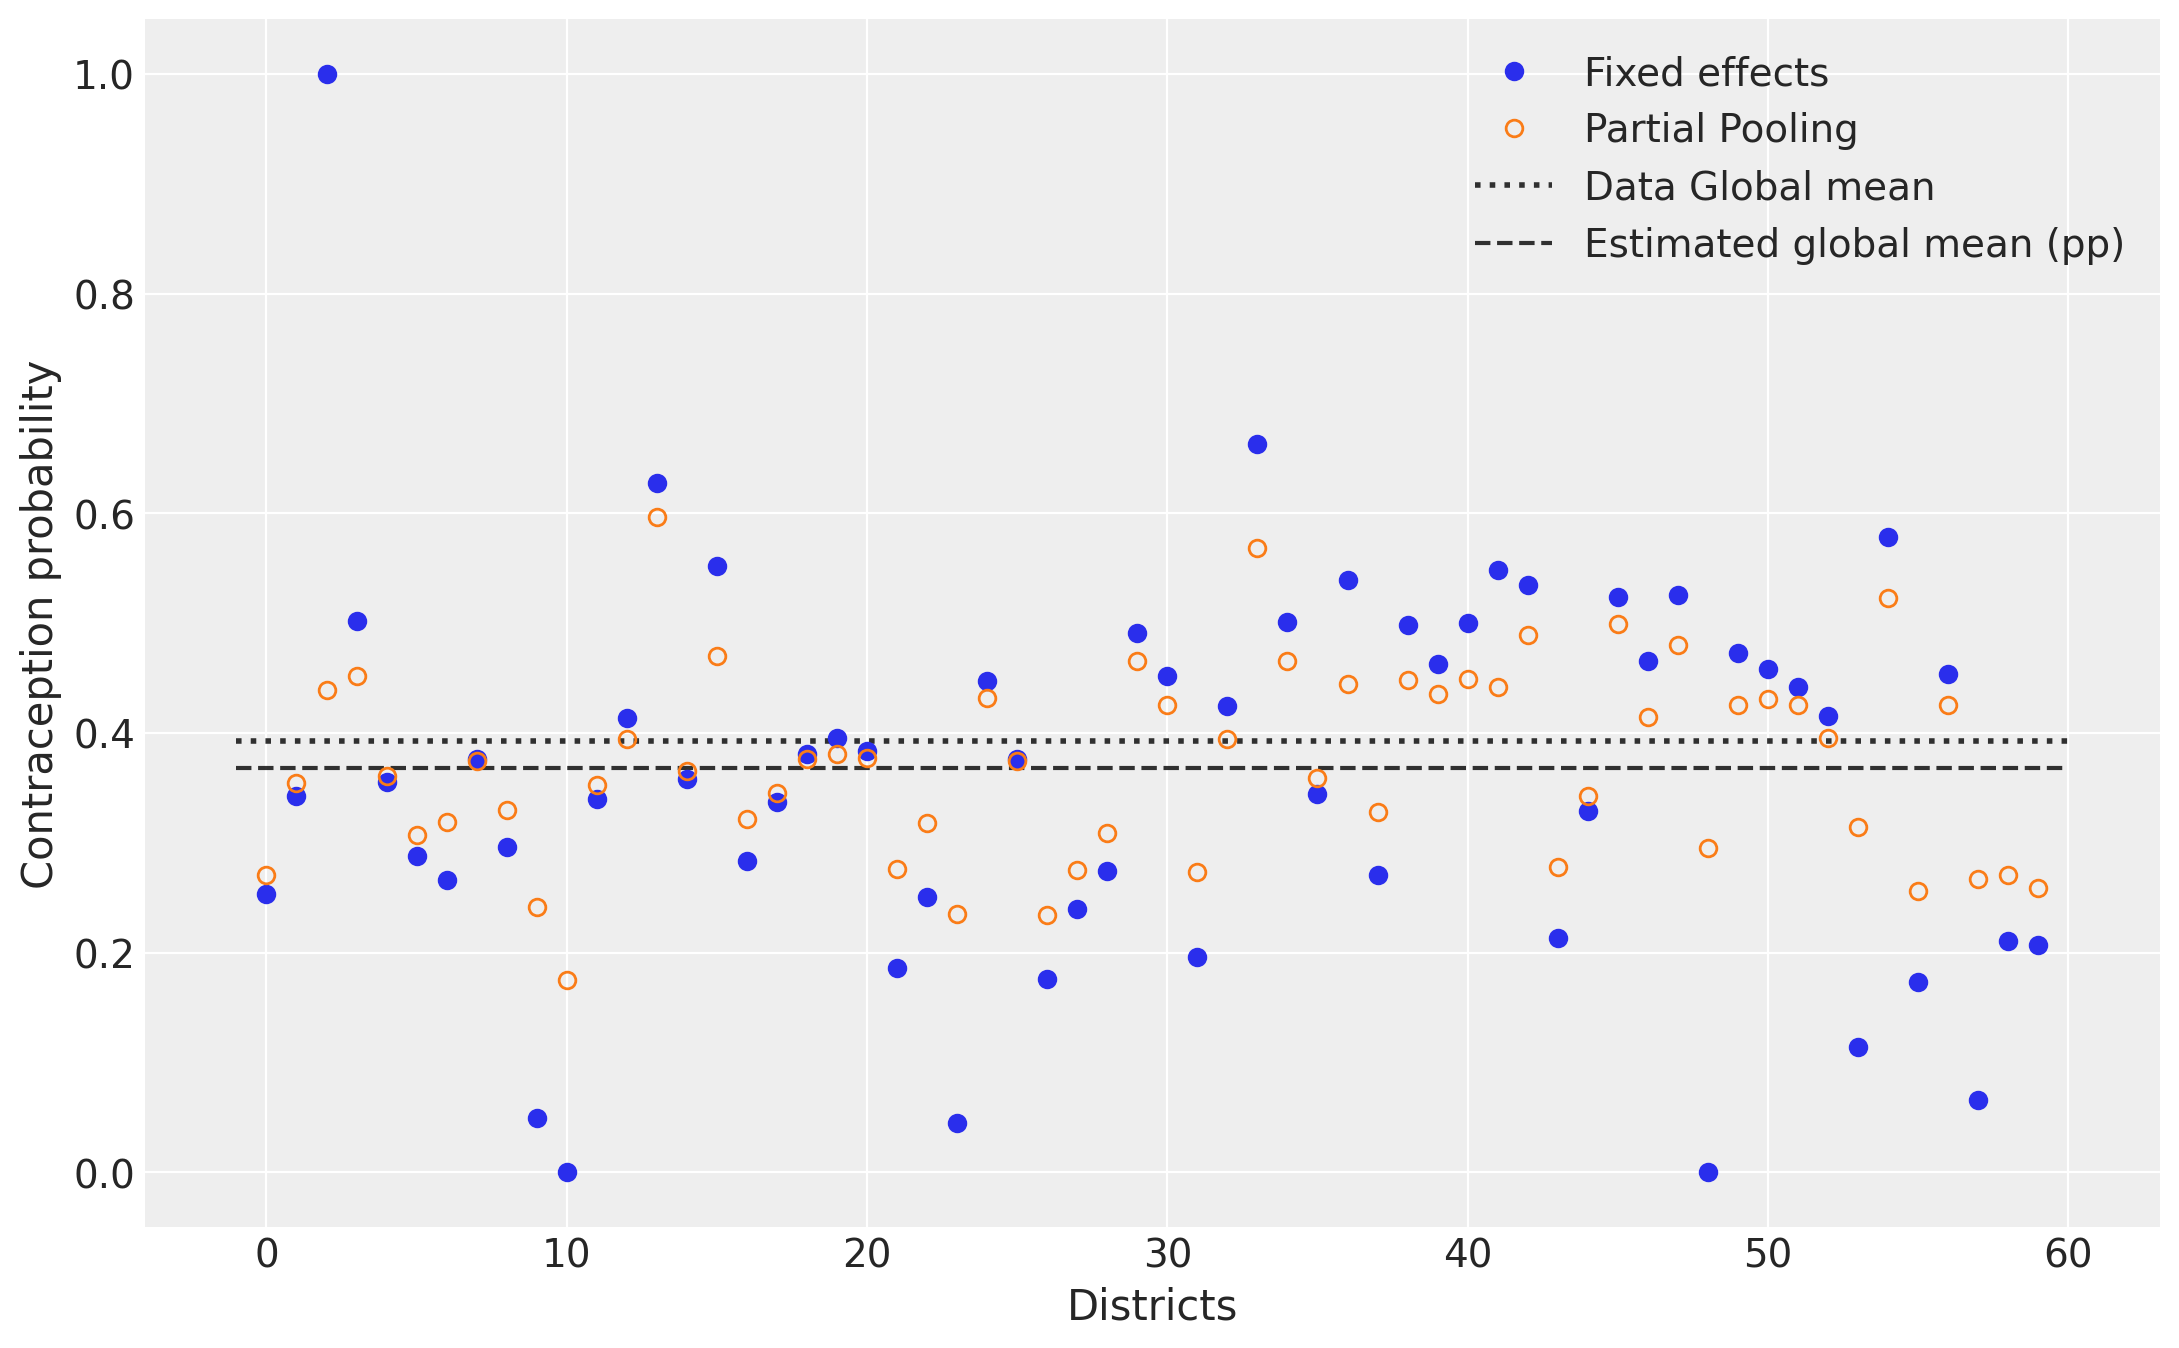

In [162]:
# From PyMC3 devs
plt.figure(figsize = (13, 8))

plt.plot(np.arange(n_district), fixed_mean, "o", label="Fixed effects")
plt.plot(np.arange(n_district), pp_mean, "o", fillstyle="none", label="Partial Pooling")

plt.hlines(df["use.contraception"].mean(), -1, n_district, linestyles="dotted", label="Data Global mean", alpha=.8, lw=2)
plt.hlines(grand_mean, -1, n_district, linestyles="dashed", label = "Estimated global mean (pp)", alpha=.8)

plt.xlabel("Districts")
plt.ylabel("Contraception probability")
plt.legend();

Will get to 12H2 and 12H3 when I complete chapter 11 questions